## Transformer based NER
- XLM-RoBERTa
    - fine-tuned
    - named entity recognition across several languages
    - recognize people, location, and organizations
- Zero-shot transfer/ zero-short learning
    - use a model trained on one dataset used for predicting another set of data
 
- tags:
  - LOC (location)
  - PER (person)
  - ORG (organization)
- inside-outside-begning format (IOB2)

### tag format
- B indicates the begining of an entity
- I a consecutive token belongs to the same entity
  - eg: a name Jeff Dean
    - Jeff: B-PER
    - Dean: I-PER
    - since Jeff Dean is the same person with 2 tokens

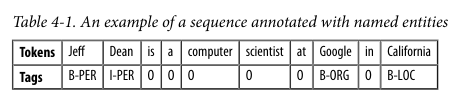





In [1]:
from datasets import get_dataset_config_names
# get_dataset_config_names -> list the available subset in the dataset

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

# now look for the configuration starting with 'PAN'
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

XTREME has 183 configurations


['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [2]:
# Load English dataset
from datasets import load_dataset

data = load_dataset('xtreme', name='PAN-X.en')
data

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [3]:
data['train'][0]

{'tokens': ['R.H.',
  'Saunders',
  '(',
  'St.',
  'Lawrence',
  'River',
  ')',
  '(',
  '968',
  'MW',
  ')'],
 'ner_tags': [3, 4, 0, 3, 4, 4, 0, 0, 0, 0, 0],
 'langs': ['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en']}

In [4]:
element = data['train'][0]
for key, value  in element.items():
  print(f'{key}: {value}')

tokens: ['R.H.', 'Saunders', '(', 'St.', 'Lawrence', 'River', ')', '(', '968', 'MW', ')']
ner_tags: [3, 4, 0, 3, 4, 4, 0, 0, 0, 0, 0]
langs: ['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en']


In [5]:
data['train'].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None),
 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [6]:
# ner tag labels
tags = data['train'].features['ner_tags'].feature
print(tags)

# create tag names
def create_tag_names(batch):
  return {'ner_tag_str': [tags.int2str(items) for items in batch['ner_tags']]}
  # ner_tags: column names
  # the class featurs has a method int2str

data = data.map(create_tag_names)
# the map function except a function
# function returns a dictionary with key as column name
# value: a list

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
# now we have the ner tags in human readable forms
for key, value in data['train'][0].items():
  print(f'{key}: {value}')

tokens: ['R.H.', 'Saunders', '(', 'St.', 'Lawrence', 'River', ')', '(', '968', 'MW', ')']
ner_tags: [3, 4, 0, 3, 4, 4, 0, 0, 0, 0, 0]
langs: ['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en']
ner_tag_str: ['B-ORG', 'I-ORG', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O']


In [8]:
# count the ner_tags in different splits
from collections import defaultdict, Counter
import pandas as pd

split2freq = defaultdict(Counter)
for split, dataset in data.items():
  for row in dataset['ner_tag_str']:
    for tag in row:
      if tag.startswith('B'):
        tag_type = tag.split('-')[1]
        split2freq[split][tag_type] += 1
pd.DataFrame.from_dict(split2freq, orient='index')

# more or less balanced data

,ORG,PER,LOC
train,9422,9164,9345
validation,4677,4635,4834
test,4745,4556,4657


In [9]:
from transformers import AutoTokenizer

bert_model_name = 'bert-base-cased'
xlmr_model_name = 'xlm-roberta-base'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xmlr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

# XML R tokenizer is a Sentenceiece insted of WordPiece tokenizer

text = 'Jack Sparrow loves New York!'
bert_tokens = bert_tokenizer(text).tokens()
xmlr_tokens = xmlr_tokenizer(text).tokens()

print(bert_tokens)
print(xmlr_tokens)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/home/aneesh/python/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']
['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']


- insted of [CLS] and [SEP] tokens in WordPiece tokenizer the XLM-R tokenizer uses \<s> and \</s> tokens to denote the start and end of the sentence.

## Tokenization Pipeline
- the process flow
  - <b> Normalization -> Pretokenization -> Tokenizer model -> Post processing </b>

### Normalization
- make the text cleaner
- common operations are
  - stripping white spaces
  - removing accented characters
  - Unicode normalization
    - various way to write the same character
    - make it standard
  - to convert to lower case (optional)

### Pretokenization
- split text into smaller objects
- a good example will be text into words


### Tokenizer model
- subword splitting model on words
- trained on the corpus
- to reduce the number of tokens in the voccabulary
- assign numbers to the tokens

### Postprocessing
- adding special tokens at the beginning and end of the words

## SentencePiece Tokenizer
- based on a subword segmentation called Unigram
- encode input text as a sequence of Unicode characters
- helps to tokenize multilingual corpora
- White space is assigned with _ (U+2581) character


## Transformers for Named Entity Recognition

### Classification architecture
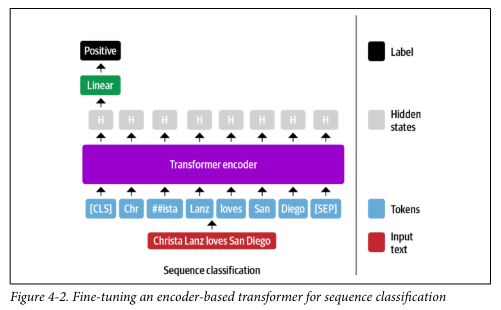

- only using the CLS head for classification

### Named entity recognition architecture
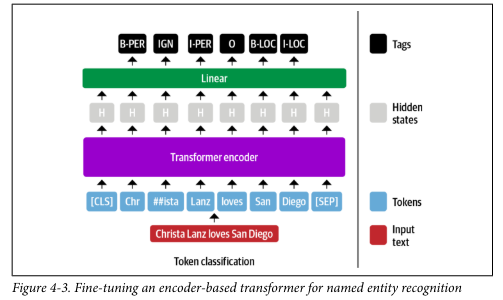

- each token is classified
- NER: a token classification task
- suppose, Christina is divided into subtokens
  - Chr and ##istina then take the assigned token for Chr and omit the other token

## Trnasformer model class
- naming convention: AutoModelFor<Task>
    - for Sequnece to Sequnace genearation: AutoModelForSeq2SeqLM

### Bodies and Heads
- model = Body + classification head (task-specific)
- Body = token_embeddings + transformer layers -> task agnostic
- BertModel or GPT2Model -> task agnostic
- BertForMaskedLM/ BertForSequenceClassification -> specific task

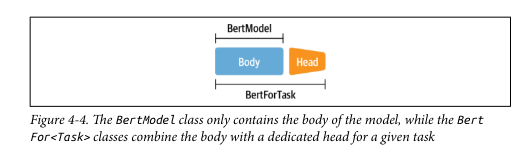

## Custom Model for Tag Classification

In [ ]:
from transformers import AutoConfig
from transformers import AutoModel
import torch

xlmr_model_name = 'xlm-roberta-base'

# need to import data before this
# tag is data['train'].features['ner_tags'].feature
# this information can be obtained from printing data
index2tag = {idx: tag for idx, tag in enumerate(tag.names)}
tag2index = {tag: idx for idx, tag in enumerate(tag.names)}

xlmr_config = AutoConfig.from_pretrained(
    xlmr_model_name,
    num_labels=tags.num_classes,
    id2label=index2tag,
    label2id=tag2index
)

device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)

xlmr_model = AutoModel\
.from_pretrained(xlmr_model_name, config=xlmr_config)\
.to(device)
# This will not work since the model name is not for TokenClassification